<a href="https://colab.research.google.com/github/emansarahafi/KNN-AI-Lab/blob/main/LAB_KNN_EmanSarahAfi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Mining

K-Nearest Neighbor LAB


## Introduction and Learning Goals

In this lab, we will explore classification using the K-Nearest Neighbors approach. We will use a customer churn dataset from the telecom industry, which includes customer data such as long-distance usage, data usage, monthly revenue, types of offerings, and other services purchased by customers. The data, based on a fictional telecom firm, includes several Excel files which have been combined and are available in the course materials. We are using the subset of customers who have phone accounts. Since the data includes a mix of numeric, categorical, and ordinal variables, we will load this data and do some preprocessing. Then we will use K-nearest neighbors to predict customer churn rates.

After completing this lab, you should have a working understanding of how to preprocess a variety of variables to apply the K-Nearest Neighbors algorithm, understand how to choose K, and understand how to evaluate model performance.


In [ ]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import pandas as pd, numpy as np, matplotlib.pyplot as plt, os, sys, seaborn as sns

## Question 1

* We begin by importing the data. Examine the columns and data.
* Notice that the data contains a unique ID, an indicator for phone customer status, total lifetime value, total revenue, and a bank-estimated churn score. We will not be using these features, so they can be dropped from the data.
* Begin by taking an initial look at the data, including both numeric and non-numeric features.


In [ ]:
df = pd.read_csv("churndata.csv")

In [ ]:
round(df.describe(),2)

,Unnamed: 0,months,gb_mon,monthly,total_revenue,satisfaction,churn_value,churn_score,cltv
count,7043.00,7043.00,7043.00,7043.00,7043.00,7043.00,7043.00,7043.00,7043.00
mean,3521.00,32.39,20.52,64.76,3034.38,3.24,0.27,58.51,4400.30
std,2033.28,24.54,20.42,30.09,2865.20,1.20,0.44,21.17,1183.06
min,0.00,1.00,0.00,18.25,21.36,1.00,0.00,5.00,2003.00
25%,1760.50,9.00,3.00,35.50,605.61,3.00,0.00,40.00,3469.00
50%,3521.00,29.00,17.00,70.35,2108.64,3.00,0.00,61.00,4527.00
75%,5281.50,55.00,27.00,89.85,4801.15,4.00,1.00,75.50,5380.50
max,7042.00,72.00,85.00,118.75,11979.34,5.00,1.00,96.00,6500.00


## Question 2

* Identify which variables are binary, categorical and not ordinal, categorical and ordinal, and numeric.  The non-numeric features will need to be encoded using methods we have discussed in the course.
* Start by identifying the number of unique values each variable takes, then create list variables for categorical, numeric, binary, and ordinal variables.
* Note that the variable 'months' can be treated as numeric, but it may be more convenient to transform it to an ordinal variable.
* For the other categorical variables, examine their values to determine which may be encoded ordinally.


In [ ]:
### BEGIN SOLUTION
df_uniques = pd.DataFrame([[i, len(df[i].unique())] for i in df.columns], columns=['Variable', 'Unique Values']).set_index('Variable')
df_uniques

,Unique Values
Variable,
Unnamed: 0,7043
id,7043
months,72
offer,6
phone,2
multiple,2
internet_type,4
gb_mon,50
security,2


In [ ]:
binary_variables = list(df_uniques[df_uniques['Unique Values'] == 2].index)
binary_variables

['phone',
 'multiple',
 'security',
 'backup',
 'protection',
 'support',
 'unlimited',
 'paperless',
 'churn_value']

In [ ]:
categorical_variables = list(df_uniques[(6 >= df_uniques['Unique Values']) & (df_uniques['Unique Values'] > 2)].index)
categorical_variables

['offer', 'internet_type', 'contract', 'payment', 'satisfaction']

In [ ]:
[[i, list(df[i].unique())] for i in categorical_variables]

[['offer', ['None', 'Offer E', 'Offer D', 'Offer C', 'Offer B', 'Offer A']],
 ['internet_type', ['DSL', 'Fiber Optic', 'Cable', 'None']],
 ['contract', ['Month-to-Month', 'One Year', 'Two Year']],
 ['payment', ['Bank Withdrawal', 'Credit Card', 'Mailed Check']],
 ['satisfaction', [3, 2, 1, 4, 5]]]

In [ ]:
ordinal_variables = ['offer','contract','satisfaction']

In [ ]:
df['months'].unique()

array([ 1,  8, 18, 25, 37, 27, 58, 15,  7, 11,  3, 13, 16, 24,  4, 32, 54,
        2, 21, 55,  5, 20, 65, 49, 43, 56, 52, 33, 30, 46,  9, 10, 35, 44,
       62, 14, 12, 17, 39, 68, 34, 22, 19, 23, 42, 41, 57, 38, 29, 66, 69,
       40, 31, 59, 36, 45, 53, 70, 47, 50, 51, 72, 26,  6, 28, 48, 61, 71,
       60, 64, 67, 63])

In [ ]:
ordinal_variables.append('months')

In [ ]:
# Identify numeric variables including those with string values not in other sets
numeric_variables = list(set(df.columns) - set(ordinal_variables) - set(categorical_variables) - set(binary_variables) - {'id'})
numeric_variables

['gb_mon', 'cltv', 'Unnamed: 0', 'total_revenue', 'monthly', 'churn_score']

array([[<Axes: title={'center': 'gb_mon'}>,
        <Axes: title={'center': 'cltv'}>],
       [<Axes: title={'center': 'Unnamed: 0'}>,
        <Axes: title={'center': 'total_revenue'}>],
       [<Axes: title={'center': 'monthly'}>,
        <Axes: title={'center': 'churn_score'}>]], dtype=object)

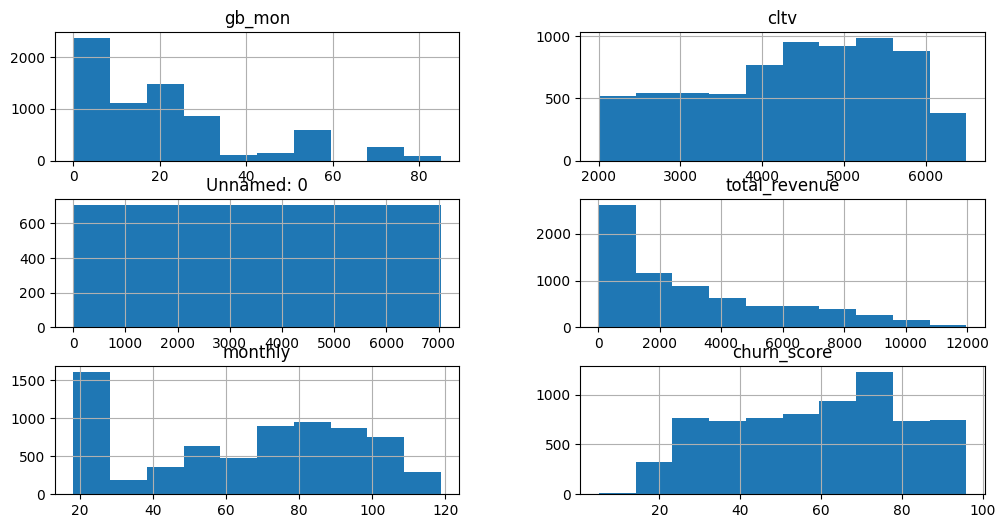

In [ ]:
df[numeric_variables].hist(figsize=(12, 6))

In [ ]:
df['months'] = pd.cut(df['months'], bins=5)

## Question 3
* Having set up the variables, remember that the K-nearest neighbors algorithm uses distance and hence requires scaled data.
* Scale the data using one of the scaling methods discussed in the course.
* Save the processed dataframe as a comma-separated file: 'churndata_processed.csv'


In [ ]:
### BEGIN SOLUTION
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, OrdinalEncoder

In [ ]:
lb, le = LabelBinarizer(), LabelEncoder()

In [ ]:
for column in ordinal_variables:
    df[column] = le.fit_transform(df[column])

In [ ]:
for column in binary_variables:
    df[column] = lb.fit_transform(df[column])

In [ ]:
categorical_variables = list(set(categorical_variables) - set(ordinal_variables))

In [ ]:
df = pd.get_dummies(df, columns=categorical_variables, drop_first=True)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

mm = MinMaxScaler()

In [ ]:
for column in [ordinal_variables + numeric_variables]:
    df[column] = mm.fit_transform(df[column])

In [ ]:
# Save a copy of the processed data for later use
outputfile = 'churndata_processed.csv'
df.to_csv(outputfile, index=False)

## Question 4
* Now that the data are encoded and scaled, separate the features (X) from the target (y, churn_value).
* Split the sample into training and test samples, with the test sample representing 40% of observations.
* Estimate a K-Nearest Neighbors model, using K=3.
* Examine the Precision, Recall, F-1 Score, and Accuracy of the classification.
* Use a graphic to illustrate the Confusion Matrix.


In [ ]:
!pip install --upgrade scikit-learn

In [ ]:
### BEGIN SOLUTION
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score

In [ ]:
# Set up X and y variables
y, X = df['churn_value'], df.drop(columns=['churn_value','id'])
# Split the data into training and test samples
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      2048
           1       0.88      0.85      0.86       770

    accuracy                           0.93      2818
   macro avg       0.91      0.90      0.91      2818
weighted avg       0.93      0.93      0.93      2818

Accuracy score:  0.93
F1 Score:  0.86


Text(0.5, 102.72222222222219, 'Ground Truth')

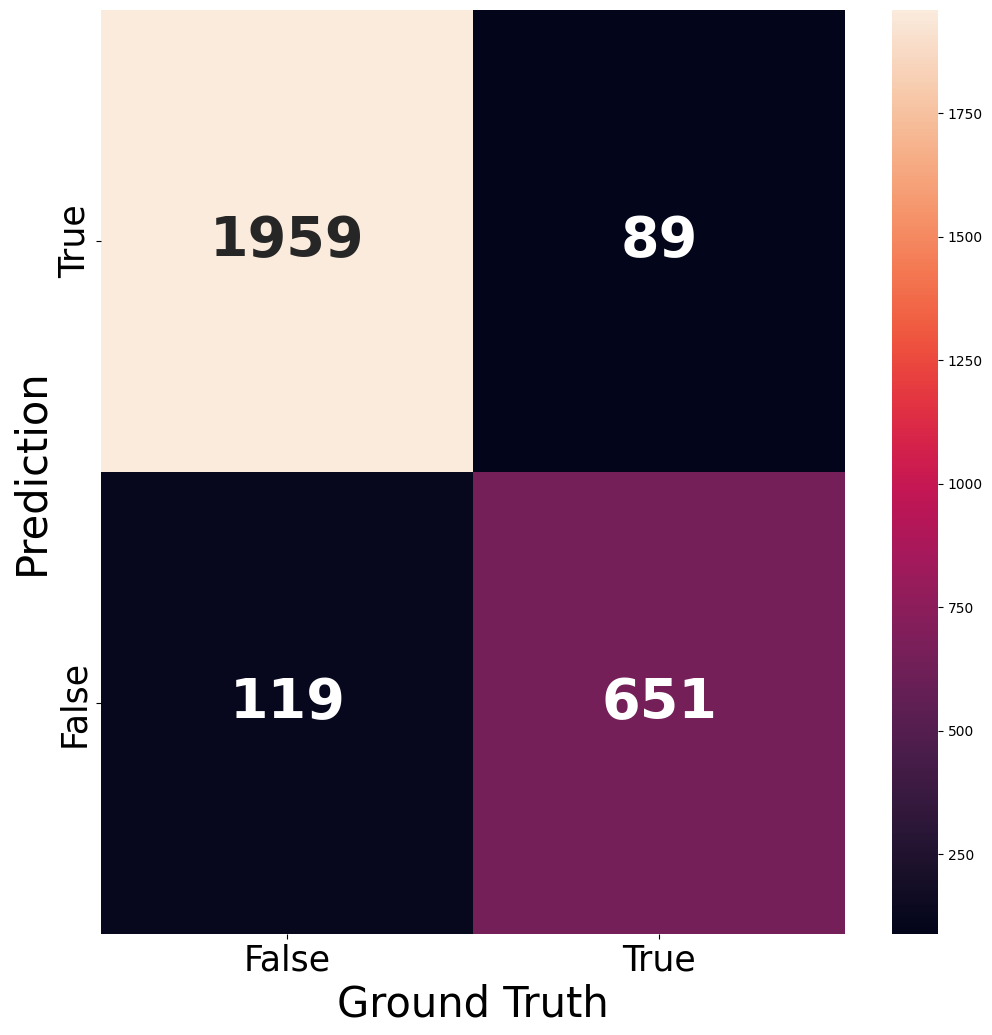

In [ ]:
# KNN model
knn = KNeighborsClassifier(n_neighbors=3)
knn = knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

# Accuracy and F1 Results
print(classification_report(y_test, y_pred))
print('Accuracy score: ', round(accuracy_score(y_test, y_pred), 2))
print('F1 Score: ', round(f1_score(y_test, y_pred), 2))

# Confusion matrix
sns.set_palette(sns.color_palette())
_, ax = plt.subplots(figsize=(12,12))
ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', annot_kws={"size": 40, "weight": "bold"})
labels = ['False', 'True']
ax.set_xticklabels(labels, fontsize=25);
ax.set_yticklabels(labels[::-1], fontsize=25);
ax.set_ylabel('Prediction', fontsize=30);
ax.set_xlabel('Ground Truth', fontsize=30)

## Question 5
* Using the same split of training and test samples, estimate another K-Nearest Neighbors model.
* This time, use K=5 and weight the results by distance.
* Again, examine the Precision, Recall, F-1 Score, and Accuracy of the classification, and visualize the Confusion Matrix.


              precision    recall  f1-score   support

           0       0.94      0.96      0.95      2048
           1       0.89      0.84      0.87       770

    accuracy                           0.93      2818
   macro avg       0.92      0.90      0.91      2818
weighted avg       0.93      0.93      0.93      2818

Accuracy score:  0.93
F1 Score:  0.87


Text(0.5, 102.72222222222219, 'Ground Truth')

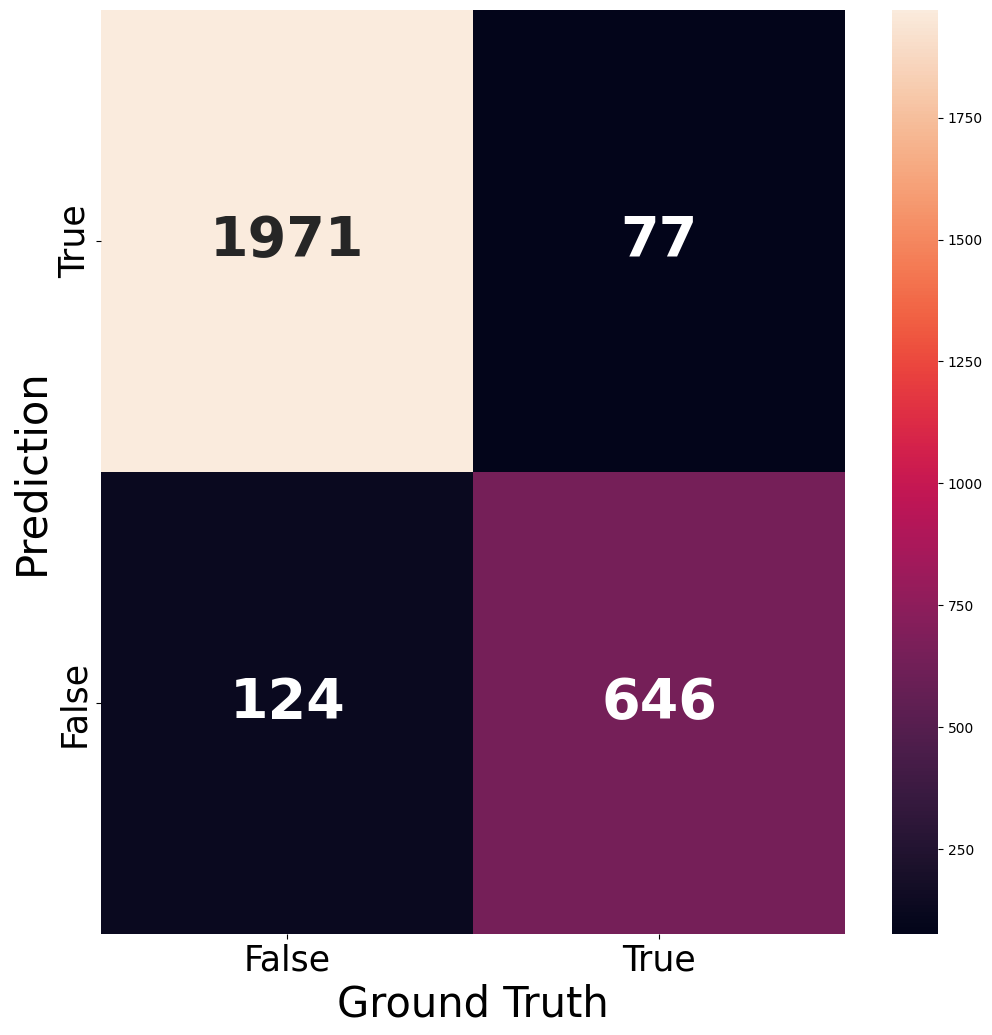

In [ ]:
# KNN model
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')
knn = knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

# Accuracy and F1 Results
print(classification_report(y_test, y_pred))
print('Accuracy score: ', round(accuracy_score(y_test, y_pred), 2))
print('F1 Score: ', round(f1_score(y_test, y_pred), 2))

# Confusion matrix
_, ax = plt.subplots(figsize=(12,12))
ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', annot_kws={"size": 40, "weight": "bold"})
labels = ['False', 'True']
ax.set_xticklabels(labels, fontsize=25);
ax.set_yticklabels(labels[::-1], fontsize=25);
ax.set_ylabel('Prediction', fontsize=30);
ax.set_xlabel('Ground Truth', fontsize=30)

## Question 6
* To determine the right value for K, examine results for values of K from 1 to 40.
* This time, focus on two measures, the F-1 Score, and the Error Rate (1-Accuracy).
* Generate charts which plot each of these measures as a function of K.
* What do these charts suggest about the optimal value for K?


Text(0.5, 1.0, 'KNN F1 Score')

<Figure size 1920x1440 with 0 Axes>

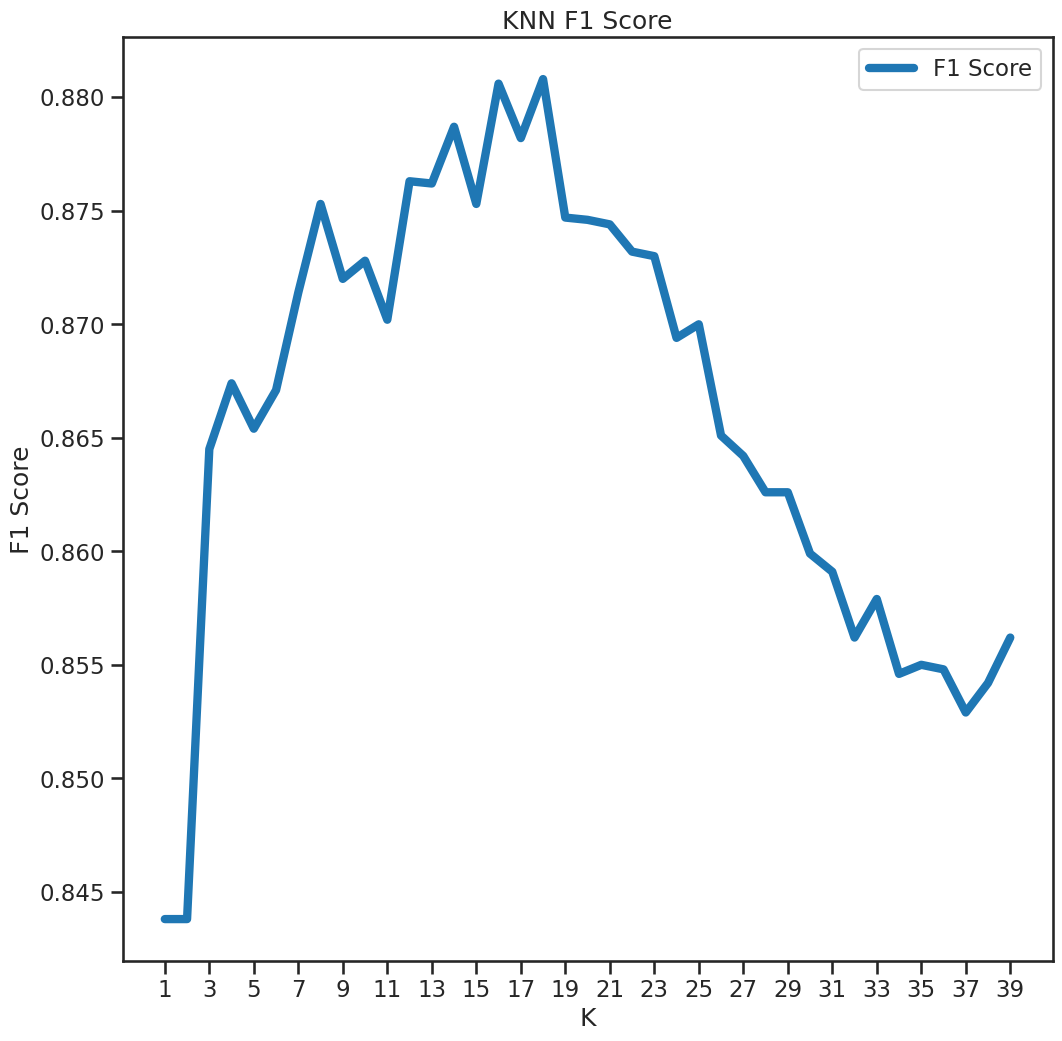

In [ ]:
max_k = 40
f1_scores = list()
error_rates = list()

for k in range(1, max_k):

    knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
    knn = knn.fit(X_train, y_train)

    y_pred = knn.predict(X_test)
    f1 = f1_score(y_pred, y_test)
    f1_scores.append((k, round(f1_score(y_test, y_pred), 4)))
    error = 1-round(accuracy_score(y_test, y_pred), 4)
    error_rates.append((k, error))

f1_results = pd.DataFrame(f1_scores, columns=['K', 'F1 Score'])
error_results = pd.DataFrame(error_rates, columns=['K', 'Error Rate'])

# Plot F1 results
sns.set_context('talk')
sns.set_style('ticks')

plt.figure(dpi=300)
ax = f1_results.set_index('K').plot(figsize=(12, 12), linewidth=6)
ax.set(xlabel='K', ylabel='F1 Score')
ax.set_xticks(range(1, max_k, 2));
plt.title('KNN F1 Score')

Text(0.5, 1.0, 'KNN Elbow Curve')

<Figure size 1920x1440 with 0 Axes>

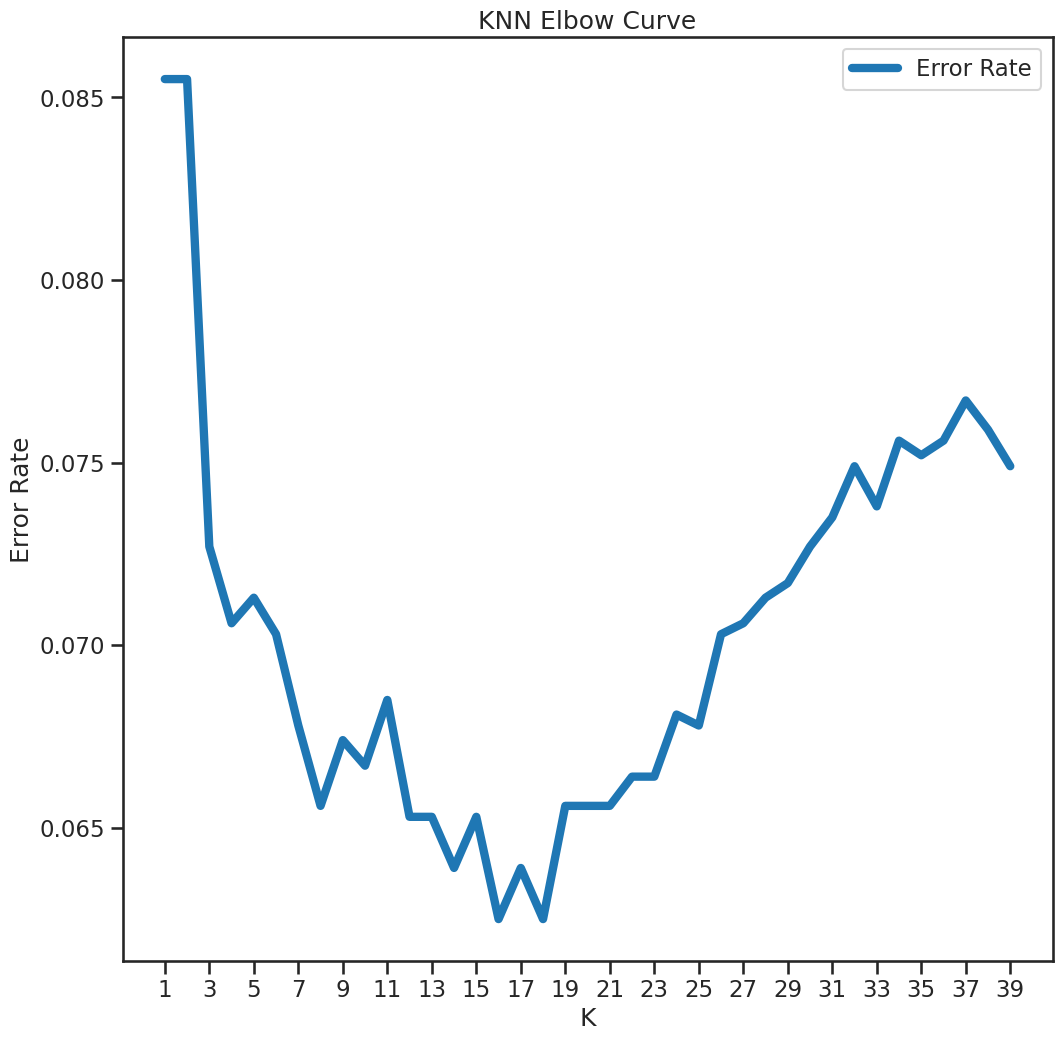

In [ ]:
# Plot Error Rate results
sns.set_context('talk')
sns.set_style('ticks')

plt.figure(dpi=300)
ax = error_results.set_index('K').plot(figsize=(12, 12), linewidth=6)
ax.set(xlabel='K', ylabel='Error Rate')
ax.set_xticks(range(1, max_k, 2))
plt.title('KNN Elbow Curve')

---
### Machine Learning Foundation (C) 2020 IBM Corporation
